<a href="https://colab.research.google.com/github/aadityasomani/Aadi/blob/master/Lesson_50_Simple_Linear_Regression_II_Aditya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 50: Simple Linear Regression II

---

### Teacher-Student Tasks

In this class, we will learn to create a simple linear regression model and deploy it to predict the relative humidity values based on the temperature values recorded in the dataset.

Let's quickly run the codes covered in the previous classes and begin this session from **Task 1: Train-Test Split**

---

### Recap

In [1]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1) 

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.1+

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

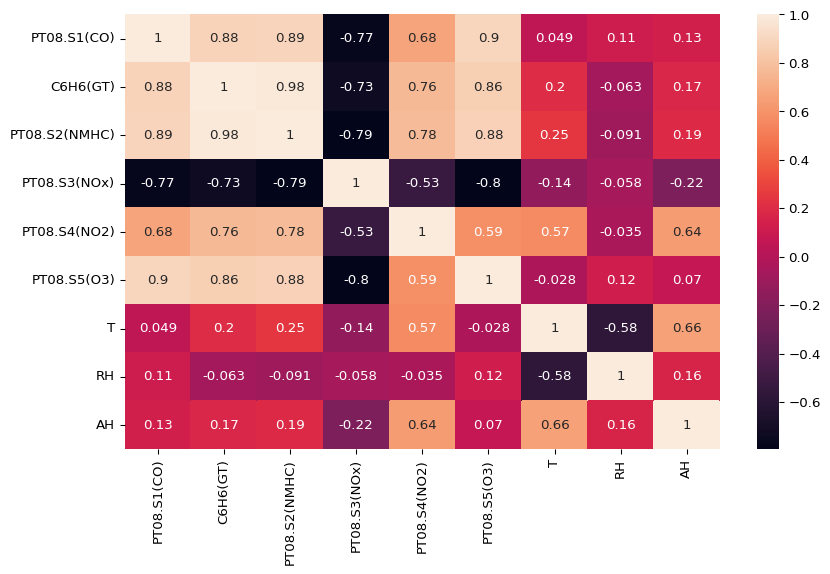

In [2]:
# Heatmap to pinpoint the columns in the 'df' DataFrame exhibiting high correlation.
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True) # 'annot=True' fills the R values in the heatmap cells.
plt.show()

---

#### Slope & Intercept

The equation of a straight line in the slope-intercept form is given by 

$$y = mx + c$$

where 

- $y$ is the $y$-coordinate of the point lying on the line
- $x$ is the $x$-coordinate of the point lying on the line
- $m$ is the slope of the line
- $c$ is the intercept made by the line on the $y$-axis

Here's an example:

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/eq-st-line1.png' width = 700></center>

The equation of the above straight line is
$$y = x - 3$$

Also, the coordinates of the point $E$ are $(0, -3)$.



---

#### Best Fit Line

In linear regression, we try to create a straight line which fits most of these points. You can create a regression plot to understand how a line fits most of these points.



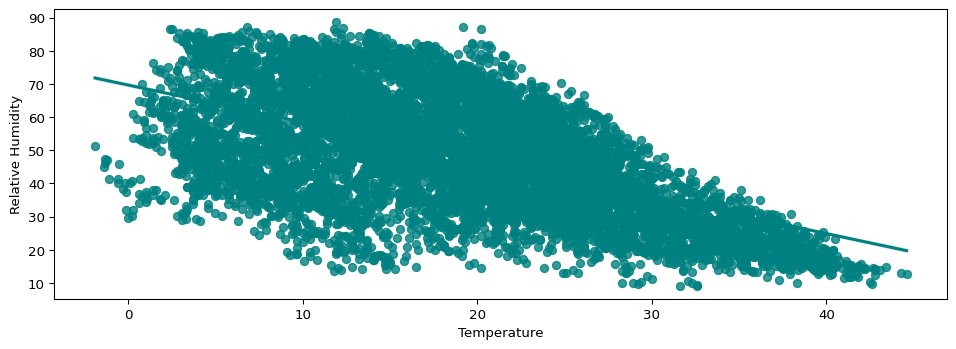

In [3]:
# Regression plot for the temperature and relative humidity columns.
plt.figure(figsize = (12, 4), dpi = 96)
sns.regplot(x = 'T', y = 'RH', data = df, color = 'teal')
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.show()

As you can see in the regression plot, a straight line having a positive slope passes through these points and tries to fit most of them.


---

#### The `ipywidgets` Module




In [4]:
# S3.2: Create an interactive Python widget to simulate a few possible lines passing through the points in the scatter plot between 'RH' & 'T.
from ipywidgets import interactive

def simulate_straight_lines(slope, intercept):
  plt.figure(figsize = (12, 5), dpi = 96)
  x_coordinates = np.arange(df['T'].min() - 10, df['T'].max() + 10) # Creating an array of numbers to plot them on the x-axis.
  plt.plot(x_coordinates, slope * x_coordinates + intercept)
  plt.scatter(df['T'], df['RH'])
  plt.xlabel('Temperature')
  plt.ylabel('Relative Humidity')
  plt.show()

interactive_plot = interactive(simulate_straight_lines, 
                               slope = (-2, 0, 0.1), # Arbitrary range of values for slope. Goes from 0 to 0.2 with a difference of 0.01
                               intercept = (-100, 100, 2)) # Arbitrary range of value for intercept. Goes from -0.5 to 1 with a difference of 0.05
interactive_plot

interactive(children=(FloatSlider(value=-1.0, description='slope', max=0.0, min=-2.0), IntSlider(value=0, desc…

---

#### Task 1: Train-Test Split

Now let's deploy a simple linear regression model. We need to split the dataset into a training set and test set wherein the training set is used to train a machine learning model and the test set is used to test the accuracy of predictions on the ML model.

Now there is no fixed rule to what should be the size of training and test sets. However, the training set should always have more instances than the test set. So in general, you can have 70% of instances in the training set and the remaining 30% in the test set. In general, you may split a DataFrame in such a way that a training set contains 67% to 80% of the instances.


To split a DataFrame, we have to: 

1. Import the `train_test_split()` function from the `sklearn.model_selection` module.

2. Separate the target variable (to be predicted) from the feature variables (predictors). In this case, we are considering one feature variable that is `T` (temperature).

3. Use the `train_test_split()` function to split the DataFrame into the training and test sets both containing feature variable(s) and the target variable. The function should take the following inputs:
   - An array containing feature variable(s)
   - An array containing target variable
   - Size of the test set i.e., value for the `test_size` parameter
   - Value for the `random_state` parameter

In [5]:
# S1.1: Split the DataFrame into the training and test sets.
from sklearn.model_selection import train_test_split
X=df['T']
y=df['RH']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42)

If you don't specify the `random_state` parameter in your code, then every time you run (or execute) your code, a new random value is generated and the training and test datasets will have different values each time.

However, if a fixed value is assigned like `random_state = 42` then regardless of the number of times you execute your code, the result will be the same i.e., same values in train and test datasets.

Let's understand this concept with the help of an example. Create two NumPy arrays containing 10 values and split them into train and test sets without passing the `random_state` parameter to the `train_test_split()` function.

In [10]:
# S1.2: Create two NumPy arrays having 10 values. split them into training and test sets without passing the 'random_state' parameter.
feature=np.arange(10)
target=np.arange(11,21)
feature_train,feature_test,target_train,target_test=train_test_split(feature,target,test_size=0.33)
print(f'feature train  ={feature_train},feature test={feature_test}')

feature train  =[3 0 4 9 8 6],feature test=[5 7 1 2]


If you run the above code again and again, you will see the values in the train and test set keep on changing every time.

Now again create two NumPy arrays containing 10 values. Split them into train and test sets and pass the `random_state` parameter as well to the `train_test_split()` function.

In [15]:
# S1.3: Create two NumPy arrays containing 10 values. Split them into train and test sets and pass the random_state parameter as well.
feature=np.arange(10)
target=np.arange(11,21)
feature_train,feature_test,target_train,target_test=train_test_split(feature,target,test_size=0.33,random_state=42)
print(f'feature train  ={feature_train},feature test={feature_test}')

feature train  =[7 2 9 4 3 6],feature test=[8 1 5 0]


If you run the above code again and again, you will see the values in the training and test set remain the same.

---

#### Task 2: Model Training

In simple linear regression, our job is to find this straight line which is called the **best fit line**. So we need to find the best fit line that can fit the most points in the scatter plot between the relative humidity and temperature values. 

Let the equation of the best fit line be $$y = mx + c$$

Here,
- $y$ represents the relative humidity values on the $y$-axis
- $x$ represents the temperatures values on the $x$-axis
- $m$ is the slope of the line
- $c$ is the intercept made by the line on the $y$-axis

The above equation can also be written as
$$\text{relative humidity} = m \times \text{temperature} + c$$

Hence, for the best fit line, the slope is given as 

$$m = \frac{(x_1 - \bar{x})(y_1 - \bar{y}) + (x_2 - \bar{x})(y_2 - \bar{y}) + (x_3 - \bar{x})(y_3 - \bar{y}) + \dots + (x_n - \bar{x})(y_n - \bar{y})}{(x_1 - \bar{x})^2 + (x_2 - \bar{x})^2 + (x_3 - \bar{x})^2 + \dots + (x_n - \bar{x})^2}$$


$$\Rightarrow m = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}$$


where 
- $x_i$ is each instance of the feature variable. In this case, $x_i$ represents each temperature value.

- $\bar{x}$ is the average (or mean) value of the feature variable. In this case, $\bar{x}$ is the average temperature value.

- $y_i$ is each instance of the target variable. In this case, $y_i$ represents each relative humidity value.

- $\bar{y}$ is the average (or mean) value of the target variable. In this case, $\bar{y}$ is the average relative humidity value.

- $n$ is the total number of instances.

The above formula may look scary to you, but if you think logically, then it is straightforward. It says
1. Subtract the mean of the feature variable ($\bar{x}$) from each instance ($x$) i.e. 
$$(x_1 - \bar{x}), (x_2 - \bar{x}), (x_3 - \bar{x}), \dots , (x_n - \bar{x})$$

2. Similarly, subtract the mean of the target variable ($\bar{y}$) from each instance ($y$) i.e. 
$$(y_1 - \bar{y}), (y_2 - \bar{y}), (y_3 - \bar{x}), \dots , (y_n - \bar{y})$$

3. Multiply the above subtractions one-by-one and add them i.e. 
$$(x_1 - \bar{x})(y_1 - \bar{y}) + (x_2 - \bar{x})(y_2 - \bar{y}) + (x_3 - \bar{x})(y_3 - \bar{y}) + \dots + (x_n - \bar{x})(y_n - \bar{y})$$

4. Square the values obtained in the first step i.e. 
$$(x_1 - \bar{x})^2, (x_2 - \bar{x})^2, (x_3 - \bar{x})^2, \dots , (x_n - \bar{x})^2$$

5. Add all the values obtained in the fourth step i.e.
$$(x_1 - \bar{x})^2 + (x_2 - \bar{x})^2 + (x_3 - \bar{x})^2 + \dots + (x_n - \bar{x})^2$$

6. Finally, divide the sum obtained in the third step by the sum obtained in the fifth step i.e.
$$m = \frac{(x_1 - \bar{x})(y_1 - \bar{y}) + (x_2 - \bar{x})(y_2 - \bar{y}) + (x_3 - \bar{x})(y_3 - \bar{y}) + \dots + (x_n - \bar{x})(y_n - \bar{y})}{(x_1 - \bar{x})^2 + (x_2 - \bar{x})^2 + (x_3 - \bar{x})^2 + \dots + (x_n - \bar{x})^2}$$

The intercept i.e. $c$ is given by 
$$c = \bar{y} - m \bar{x}$$


**Note:** The differences between a value and the mean value is also referred to as **residuals** or **errors**.

Now let's create two functions:

1. A function that calculates the errors for the feature and target variables. Let this function be `errors_product()` which doesn't take any input and returns the product of the errors.

2. A function that calculates the squared errors for the feature variable only. Let this function be `squared_errors()` which also doesn't take any input and returns the squared errors.



In [16]:
# S2.1: Create the 'errors_product()' and 'squared_errors()' function.
def errors_product():
    return ((X_train-X_train.mean())*(y_train-y_train.mean()))
def squared_errors():
    return ((X_train-X_train.mean())**2)

Now let's calculate the slope and intercept values for the best fit line by applying the formulae mentioned above.

In [17]:
# S2.2: Calculate the slope and intercept values for the best fit line.
slope=errors_product().sum()/squared_errors().sum()
intercept=y_train.mean()-slope*X_train.mean()
print(f'Slope:{slope} Intercept:{intercept}')

Slope:-1.1120539107947718 Intercept:69.69110324644882


As you can see, we have obtained the slope and intercept values for the best fit line.

Hence, the required equation of the best fit line is
$$y = -1.1120x + 69.6911$$

or
$$\text{relative humidity} =  -1.1120 \times \text{temperature} + 69.6911$$

which is also the regression line.

Let's plot this line along with the scatter plot to see how well it fits the points.

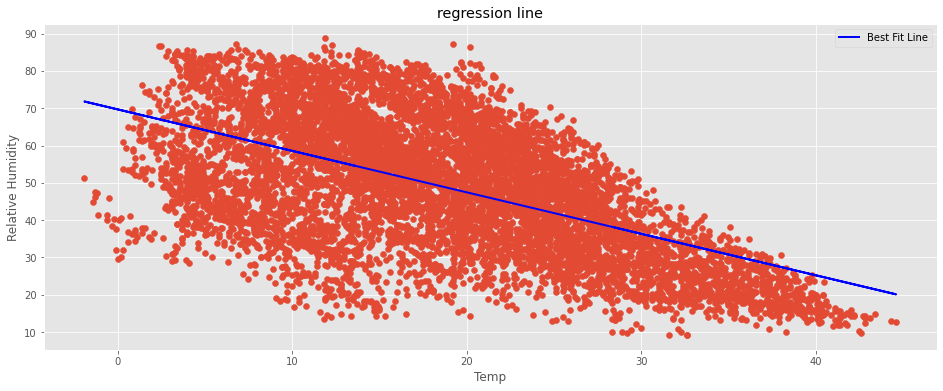

In [21]:
# S2.3: Plot the regression line in the scatter plot between relative humidity and temperature values.
plt.style.use('ggplot')
plt.figure(figsize=(16,6))
plt.title("regression line")
plt.scatter(df['T'],df['RH'])
plt.plot(df['T'],slope*df['T']+intercept,label="Best Fit Line",color='b',linewidth=2)
plt.xlabel("Temp")
plt.ylabel("Relative Humidity")
plt.legend()
plt.show()

From the naked eye observation, it seems the regression line that we obtained fits pretty well all the points in the scatter plot. 

---

#### Task 3: Prediction

Now let's predict the relative humidity values for the temperature values stored in the test set.

In [25]:
# S3.1: Predict the relative humidity values for the temperature values stored in the test set.
y_pred=slope*X_test+intercept
y_pred

2973    40.777702
3396    44.113863
4372    41.778550
6025    54.567170
7960    61.350699
          ...    
366     59.015386
8797    59.237796
7672    60.016234
3555    46.671587
4975    49.229311
Name: T, Length: 3088, dtype: float64

So we have got the predicted relative humidity values. 

Also, based on the regression line, we can create a function which takes a temperature (in degree Celsius) value as an input and returns the corresponding relative humidity value.

**Note:** The simple linear regression model that we created is applicable only to the city for which the data is collected. The data doesn't contain global temperature and relative humidity values. Hence, the simple linear regression model cannot be applied for any country, state, region or city in the world.

In [23]:
# S3.2: Create a function which takes a temperature (in degree Celsius) value as an input and returns relative humidity.
def predict_rh(temp):
    return -1.1120*temp+69.6911
predict_rh(45)

19.6511

Hence, we have got the relative humidity as 19.168 for a temperature value of 45 degree celsius.

Let's stop here. In the next class, you will learn how to evaluate the accuracy of a linear regression model.

---